## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4.,ce_weights=0.7, fcl_weights=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        
        return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl))
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss=combined_loss(ce_weights = ce_w,fcl_weights = 1 - ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 512)               0         
_________________________________________________________________
tf.__operators__.add (TFOpLa (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
tf.math.multiply_1 (TFOpLamb (None, 256)               0         
_________________________________________________________________
tf.__operators__.add_1 (TF

C:\Users\loe_lin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
49/49 [==============================] - 3s 51ms/step - loss: 6.3319 - accuracy: 0.2614 - val_loss: 5.5927 - val_accuracy: 0.3326
Epoch 2/25
49/49 [==============================] - 2s 46ms/step - loss: 5.3055 - accuracy: 0.3594 - val_loss: 5.0904 - val_accuracy: 0.3815
Epoch 3/25
49/49 [==============================] - 2s 45ms/step - loss: 4.9373 - accuracy: 0.3939 - val_loss: 4.8096 - val_accuracy: 0.4069
Epoch 4/25
49/49 [==============================] - 2s 49ms/step - loss: 4.6969 - accuracy: 0.4164 - val_loss: 4.6251 - val_accuracy: 0.4240
Epoch 5/25
49/49 [==============================] - 2s 48ms/step - loss: 4.5215 - accuracy: 0.4328 - val_loss: 4.4763 - val_accuracy: 0.4301
Epoch 6/25
49/49 [==============================] - 2s 48ms/step - loss: 4.3672 - accuracy: 0.4481 - val_loss: 4.3742 - val_accuracy: 0.4436
Epoch 7/25
49/49 [==============================] - 2s 46ms/step - loss: 4.2491 - accuracy: 0.4570 - val_loss: 4.2573 - val_accuracy: 0.4538
Epoch 8/25
49

Epoch 21/25
49/49 [==============================] - 3s 55ms/step - loss: 2.8548 - accuracy: 0.5328 - val_loss: 3.0614 - val_accuracy: 0.4985
Epoch 22/25
49/49 [==============================] - 3s 63ms/step - loss: 2.8366 - accuracy: 0.5326 - val_loss: 3.0514 - val_accuracy: 0.5012
Epoch 23/25
49/49 [==============================] - 3s 60ms/step - loss: 2.7864 - accuracy: 0.5410 - val_loss: 3.0041 - val_accuracy: 0.5034
Epoch 24/25
49/49 [==============================] - 3s 53ms/step - loss: 2.7501 - accuracy: 0.5433 - val_loss: 2.9871 - val_accuracy: 0.5070
Epoch 25/25
49/49 [==============================] - 2s 46ms/step - loss: 2.7360 - accuracy: 0.5446 - val_loss: 2.9942 - val_accuracy: 0.5058
Numbers of exp: 2, ce_weight: 0.50
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
________________________________________

Epoch 3/25
49/49 [==============================] - 2s 45ms/step - loss: 2.8893 - accuracy: 0.3588 - val_loss: 2.8317 - val_accuracy: 0.3717
Epoch 4/25
49/49 [==============================] - 2s 36ms/step - loss: 2.7759 - accuracy: 0.3806 - val_loss: 2.7363 - val_accuracy: 0.3868
Epoch 5/25
49/49 [==============================] - 2s 43ms/step - loss: 2.6941 - accuracy: 0.3953 - val_loss: 2.6649 - val_accuracy: 0.4015
Epoch 6/25
49/49 [==============================] - 2s 40ms/step - loss: 2.6279 - accuracy: 0.4087 - val_loss: 2.6116 - val_accuracy: 0.4062
Epoch 7/25
49/49 [==============================] - 2s 51ms/step - loss: 2.5728 - accuracy: 0.4184 - val_loss: 2.5601 - val_accuracy: 0.4213
Epoch 8/25
49/49 [==============================] - 2s 49ms/step - loss: 2.5239 - accuracy: 0.4303 - val_loss: 2.5104 - val_accuracy: 0.4293
Epoch 9/25
49/49 [==============================] - 2s 48ms/step - loss: 2.4794 - accuracy: 0.4375 - val_loss: 2.4776 - val_accuracy: 0.4348
Epoch 10/25
4

Epoch 23/25
49/49 [==============================] - 3s 59ms/step - loss: 1.5354 - accuracy: 0.4647 - val_loss: 1.5515 - val_accuracy: 0.4508
Epoch 24/25
49/49 [==============================] - 3s 52ms/step - loss: 1.5252 - accuracy: 0.4674 - val_loss: 1.5439 - val_accuracy: 0.4558
Epoch 25/25
49/49 [==============================] - 2s 48ms/step - loss: 1.5164 - accuracy: 0.4720 - val_loss: 1.5368 - val_accuracy: 0.4584


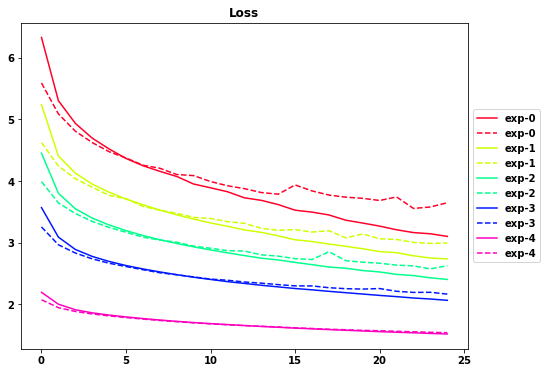

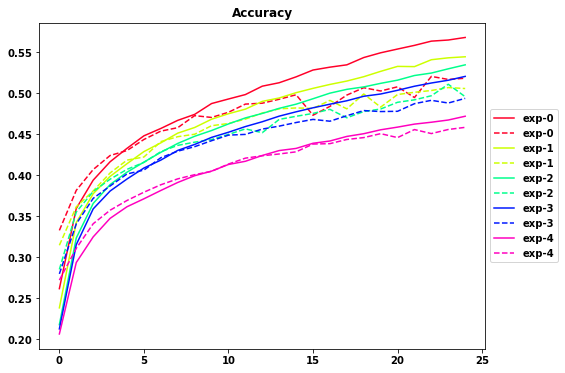

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()